In [ ]:
!pip3 install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633739 sha256=54ebb96bb4803f4d9175d898c5d38b397982aa4bcfb1af36ece45b00b6291cb8
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import zipfile
# from zipfile import ZipFile

from os import listdir
from os.path import isfile, join

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV

colab = True  # Type True if using Google Colab, type False if using Jupyter Notebook
if colab:
    from google.colab import drive
    from zipfile import ZipFile

In [ ]:
if colab:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
if colab:
    data = 'drive/MyDrive/Netflix_rec/data/Netflix_Dataset_Rating.zip'

    with ZipFile(data, 'r') as zip_ref:
        zip_ref.extractall()

## The purpose of this exercise

In this short project, we explore a shortened version of the data provided on Kaggle Netflix recommender competition. We will build a simple recommnder system using the Surprise library, and test its results. 

I am new to recommender systems and the Surprise library, my approach has been informed by the following posts:
- https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

### Loading the dataset

In [ ]:
df = pd.read_csv('Netflix_Dataset_Rating.csv')
#train = pd.read_csv('Netflix_Dataset_Movie.csv')

print('The train dataset has the shape {}'.format(df.shape))

The train dataset has the shape (17337458, 3)


### Take a sample of the dataset 

This dataset has over 17M rows, which will make it difficult for some of the models in this project to work. We will instead take a sameple of this dataset instead. 

In [ ]:
train = df.sample(frac=.3, replace=False, random_state=29)

In [ ]:
train.shape

(5201237, 3)

In [ ]:
train.head()

,User_ID,Rating,Movie_ID
12551515,1311480,3,3333
2915657,2070820,4,758
10816810,876627,2,2874
8172500,2279710,4,2171
4967901,2259483,3,1367


In [ ]:
train['User_ID'].describe()

count    5.201237e+06
mean     1.321404e+06
std      7.647396e+05
min      6.000000e+00
25%      6.602690e+05
50%      1.316700e+06
75%      1.984069e+06
max      2.649429e+06
Name: User_ID, dtype: float64

I will take a slice of the data frame by eliminating the number of movies in the dataset. If I were to take a random sample of the dataset but maintain the same number of movies and users, we will have a matrix where each movie has a small % of people that have rated it, and it will make a very sparse matrix and good predictions will be more difficult to make. 

### Let's explore the data and do some EDA

In [ ]:
# Are there any null values in the data?
train.isnull().sum()

User_ID     0
Rating      0
Movie_ID    0
dtype: int64

In [ ]:
# Are there any duplicates in the data?
train.duplicated().sum()

0

In [ ]:
train.head()

,User_ID,Rating,Movie_ID
12551515,1311480,3,3333
2915657,2070820,4,758
10816810,876627,2,2874
8172500,2279710,4,2171
4967901,2259483,3,1367


In [ ]:
#number of movies in the dataset
num_movies = train['Movie_ID'].nunique()
num_users = train['User_ID'].nunique()

print('There are {} unique movies and {} unique users in the database.'.format(num_movies, num_users))

There are 1350 unique movies and 143457 unique users in the database.


### Distribution of ratings

Movies are rated from a scale between 1 - 5, because our recommender system will try to predict ratings, it is important to get a sense of the distribution of overall ratings. Are movies most likely to be rated a 5, or 4, etc. This is important to look out for biases in our predictions. 

In [ ]:
train['Rating'].value_counts(normalize=True)

4    0.340338
3    0.299246
5    0.217274
2    0.101547
1    0.041595
Name: Rating, dtype: float64

In [ ]:
ratings = train['Rating'].value_counts()
ratings = ratings.sort_index()

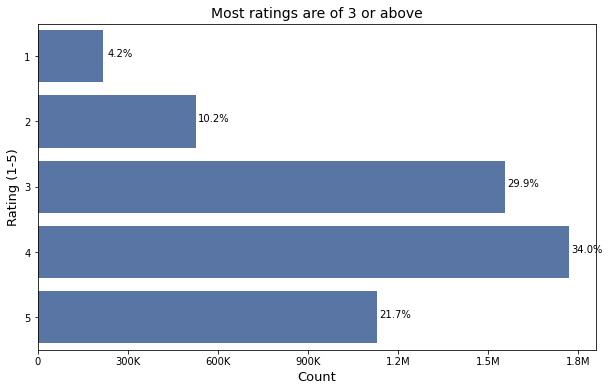

In [ ]:
x_ticks = ['0', '300K', '600K', '900K', '1.2M', '1.5M', '1.8M']
x_pos = [0, 300_000, 600_000, 900_000, 1_200_000, 1_500_000, 1_800_000]
plt.figure(figsize=(10,6))
sns.countplot(data=train, y=train['Rating'], color='#4C72B0')
plt.xticks(ticks= x_pos,labels=x_ticks)
plt.title('Most ratings are of 3 or above', fontdict={'size':14})
plt.ylabel('Rating (1-5)', fontdict={'size':13})
plt.xlabel('Count', fontdict={'size':13})

for i in range(1, 6):
    pct = ratings[i]/ratings.sum()
    pct_string = '{}%'.format(round(100*pct, 1))
    plt.text(ratings[i]+60000, i-1, pct_string, ha='center')

### Distribution of users that have rated the movies in the dataset

It's important to get a sense of how many users have rated the movies in our dataset. Ratings of movies that have been rated by less users will be harder to predict, and movies that have been rated by many users will be easier to predict. 

In [ ]:
count_rated = train.groupby('Movie_ID')[['User_ID']].count().sort_values(by='User_ID', ascending=True)

In [ ]:
count_rated.rename(columns={'User_ID':'Count'}, inplace=True)

count_rated.describe()

,Count
count,1350.000000
mean,3852.768148
std,5339.697294
min,321.000000
25%,793.750000
50%,1554.000000
75%,4411.000000
max,35126.000000


Taking count of how many times each movie has been rated and looking at summary statistics above that about 50% of movies have been rated by less than 793 users. At the maximum, there is a movie that was rated by 35,126 users (out of 143,457 users, this is the most popular movie on the dataset!). At a minimum, there is a movie that was rated by 321 users. 

We can get a little more insight into this distribution with a plot. 

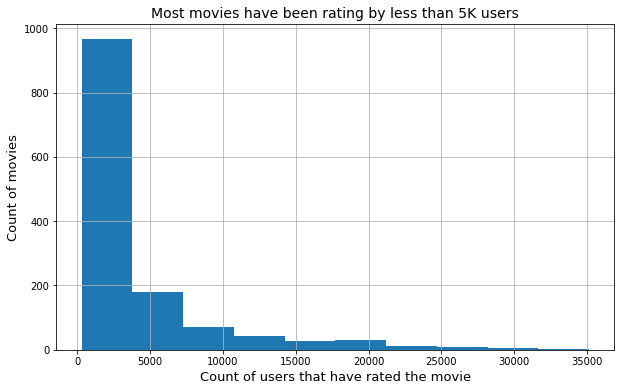

In [ ]:
count_rated.hist(figsize=(10,6))
plt.title('Most movies have been rating by less than 5K users', fontdict={'size':14})
plt.ylabel('Count of movies', fontdict={'size':13})
plt.xlabel('Count of users that have rated the movie', fontdict={'size':13});

### Distribution of movies that users rated

We want to get a sense of how many movies our users tend to rate. For user that have rated many movies, their ratings for other movies will be easier to predict, and for users that have not made many predictions, their ratings will be harder to predict. 

In [ ]:
count_user_rating = train.groupby('User_ID')[['Movie_ID']].count().sort_values(by='Movie_ID', ascending=True)

In [ ]:
count_user_rating.rename(columns={'Movie_ID':'Count'}, inplace=True)

count_user_rating.describe()

,Count
count,143457.000000
mean,36.256418
std,24.487905
min,1.000000
25%,20.000000
50%,29.000000
75%,44.000000
max,421.000000


About 50% of users have rated 29 movies or less. At minimum, we have user that has only rated 1 movie, and at a maximum, we have a user that has rated 421 movies (out of 1350).

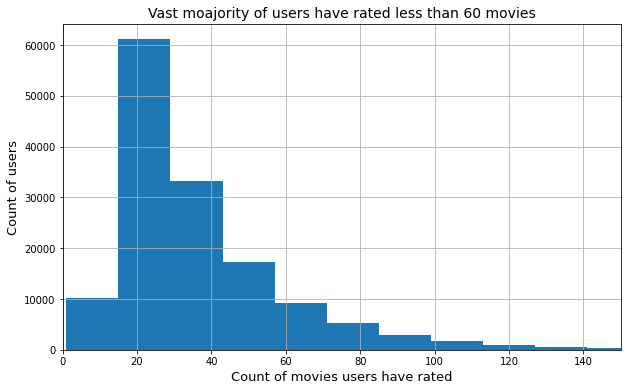

In [ ]:
count_user_rating.hist(figsize=(10,6), bins=30)
plt.title('Vast moajority of users have rated less than 60 movies', fontdict={'size':14})
plt.ylabel('Count of users', fontdict={'size':13})
plt.xlabel('Count of movies users have rated', fontdict={'size':13})
plt.xlim(right=150, left=0);

### Prepare the data for Surprise library

For this project, we will reduce the dimentionality of the dataset by filtering out users that have not rated many movies and filtering out movies that have not been rated by many users. For both of these groups, there will not be much information to base good predictions upon. We will produce better results by eliminating them from the dataset for now. Another reason to further reduce dimensionality is that for this project we are working with no more than 52 GB of RAM and these algorithms will require more power if we include the entire dataset.   

In [ ]:
total_users = train['User_ID'].nunique()
total_books = train['Movie_ID'].nunique()

#setting threshhold for movies that have been rated at least by 5% of users 
thresh_ratings = int(.05*total_users) 

#setting threshhold for users that have rated at least 5% of movies
thresh_rated = int(.05*total_books)

In [ ]:
filter_movies = train['Movie_ID'].value_counts() > thresh_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

filter_users = train['User_ID'].value_counts() > thresh_rated
filter_users = filter_users[filter_users].index.tolist()

new_train = train[(train['Movie_ID'].isin(filter_movies)) & (train['User_ID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train.shape))
print('The new data frame shape:\t{}'.format(new_train.shape))

The original data frame shape:	(5201237, 3)
The new data frame shape:	(563759, 3)


In [ ]:
print('We have {} unique users'.format(new_train['User_ID'].nunique()))
print('We have {} unique movies'.format(new_train['Movie_ID'].nunique()))

We have 14054 unique users
We have 207 unique movies


Let's look at the distribution of the number of movies that the users in the new dataset have rated.

In [ ]:
new_count_user_rating = new_train.groupby('User_ID')[['Movie_ID']].count()
new_count_user_rating.rename(columns={'Movie_ID':'Count'}, inplace=True)
new_count_user_rating.describe()

,Count
count,14054.000000
mean,40.113775
std,8.150418
min,13.000000
25%,35.000000
50%,40.000000
75%,45.000000
max,74.000000


Let's look at the distribution of the number of ratings that the movies have received from users

In [ ]:
new_count_rating = new_train.groupby('Movie_ID')[['User_ID']].count()
new_count_rating.rename(columns={'User_ID':'Count'}, inplace=True)
new_count_rating.describe()

,Count
count,207.000000
mean,2723.473430
std,635.142915
min,1260.000000
25%,2237.500000
50%,2777.000000
75%,3142.000000
max,4196.000000


To user Surprise, we will load the dataset from a pandas datafram using the load_from_df() method. The dataframe's columns has to be in the order of user_id, item_id, and rating. 

In [ ]:
data = new_train.reindex(columns=['User_ID', 'Movie_ID', 'Rating'])

In [ ]:
data.head()

,User_ID,Movie_ID,Rating
4909586,1894544,1324,4
11019650,1083069,2922,5
12791908,2341658,3385,3
14890468,1069602,3905,4
7845737,2297136,2122,4


In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['User_ID', 'Movie_ID', 'Rating']], reader)

With the surprise library, we will try out a few of their algorithms and select the one that provides the lowest rmse. We will try out the following:

- BaselineOnly

**KNN Algorithms**


- KNNWithMeans


**Matrix Factorization-based Algorithms**

- SVD




In [ ]:
!pip install tqdm

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in tqdm([SVD(), KNNWithMeans(), BaselineOnly()]):
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

 33%|███▎      | 1/3 [01:28<02:56, 88.03s/it]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 67%|██████▋   | 2/3 [22:23<12:54, 774.66s/it]

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


100%|██████████| 3/3 [22:39<00:00, 453.06s/it]


In [ ]:
# results_2

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.906359,25.711068,2.376215
BaselineOnly,0.917614,2.298399,1.754009
KNNWithMeans,0.923274,91.966545,325.205908


We got the best result from the SVD model. Below I will used GridSearchCV to find the best hyper-parameters for this model. 

In [ ]:
# Set parameters for Gridsearch on SVD

parameters= {'n_factors': [50, 100, 150],
             'reg_all': [0.02, 0.1],
             'n_epochs': [20, 30],
             'lr_all': [.005, .01]}

gridsvd = GridSearchCV(SVD, param_grid=parameters, measures=['rmse'])

# Fit SVD model on data
gridsvd.fit(data)

In [ ]:
best = gridsvd.best_params['rmse']
best


{'lr_all': 0.01, 'n_epochs': 30, 'n_factors': 150, 'reg_all': 0.1}

In [ ]:
print('Using SVD with the best GridSearch params')

algo = SVD(n_factors= best['n_factors'],
             reg_all = best['reg_all'],
             n_epochs = best['n_epochs'],
             lr_all= best['lr_all'])

trainset, testset = train_test_split(data, test_size=0.25)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Using SVD with the best GridSearch params
RMSE: 0.8824


0.8823829708216288

With a root mean squared error of 0.88, we can more or less gauge that our model tends to misspredict someone's rating by +/- 0.88. 

However, note that rmse tends to greatly penalize larger errors, so in cases where the actual rating was say, 1 but the model predicts a 5, rmse is imposing a much greater penalty on that error than on 4 occassion where the rating was missed by 1 rating point. 

In [ ]:
accuracy.mae(predictions)

MAE:  0.6954


0.6953928835640425

The mean squared error does not impose such penalty, and shows us that on average, the model is mispredicting ratings by 0.70 rating points. 

In [ ]:
trainset = algo.trainset

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,1985504,3684,3.0,3.764199,{'was_impossible': False},31,1866,0.764199
1,2432474,2470,2.0,3.153183,{'was_impossible': False},35,2483,1.153183
2,1181784,3825,3.0,3.333126,{'was_impossible': False},43,2428,0.333126
3,70125,3315,4.0,4.289948,{'was_impossible': False},28,1232,0.289948
4,1048629,1659,5.0,3.580244,{'was_impossible': False},34,2143,1.419756


After exploring the rmse and mae for the errors, we saw that ratings where being missed by less than 1 rating point (on average). It would be interesting to see as well, what the distribution of our errors looked like. 

In [ ]:
df['err'].describe()

count    140940.000000
mean          0.695393
std           0.543167
min           0.000000
25%           0.276271
50%           0.578477
75%           0.989581
max           4.000000
Name: err, dtype: float64

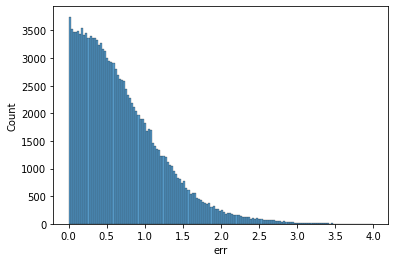

In [ ]:
sns.histplot(df['err']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


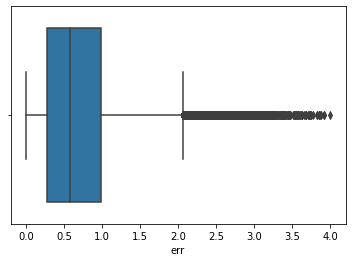

In [ ]:
sns.boxplot(df['err']);

The vast majority of errors are of 1 rating point or less. In fact, about 25% of ratings were missed by only .27 rating points. 

Errors of above 2 rating points are outliers. 


In [ ]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17807,2624910,2862,5.0,5.0,{'was_impossible': False},29,3009,0.0
119142,1096159,4306,5.0,5.0,{'was_impossible': False},23,3113,0.0
137508,2072167,1798,5.0,5.0,{'was_impossible': False},29,2746,0.0
18154,844028,3538,5.0,5.0,{'was_impossible': False},38,1969,0.0
66484,2056657,1905,5.0,5.0,{'was_impossible': False},19,3153,0.0
130741,1664010,2862,5.0,5.0,{'was_impossible': False},44,3009,0.0
58926,2516525,1905,5.0,5.0,{'was_impossible': False},37,3153,0.0
134963,494440,886,5.0,5.0,{'was_impossible': False},30,1935,0.0
70481,2349595,886,5.0,5.0,{'was_impossible': False},30,1935,0.0
70494,1252539,1220,5.0,5.0,{'was_impossible': False},31,2361,0.0


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
121711,2088784,3538,1.0,4.775815,{'was_impossible': False},22,1969,3.775815
29532,2327365,3290,1.0,4.825459,{'was_impossible': False},23,2274,3.825459
2714,1126697,2452,1.0,4.826429,{'was_impossible': False},30,2981,3.826429
42090,1699606,482,1.0,4.854717,{'was_impossible': False},32,1371,3.854717
48154,1952860,457,1.0,4.857172,{'was_impossible': False},24,2463,3.857172
51749,1252539,4302,1.0,4.860337,{'was_impossible': False},31,2106,3.860337
73606,1400378,2122,1.0,4.884381,{'was_impossible': False},33,2249,3.884381
111886,1400378,1324,1.0,4.912012,{'was_impossible': False},33,2233,3.912012
130255,1494196,270,1.0,4.918877,{'was_impossible': False},22,1105,3.918877
10162,844028,1905,1.0,5.000000,{'was_impossible': False},38,3153,4.000000


The worst prediction was for item 2452 and for user 2482783, I am curious to know how many users have rated this item and how many items has this user rated.

In [ ]:
new_train.loc[new_train['Movie_ID']==2452]['Rating'].describe()


count    3982.000000
mean        4.432697
std         0.889169
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: Rating, dtype: float64

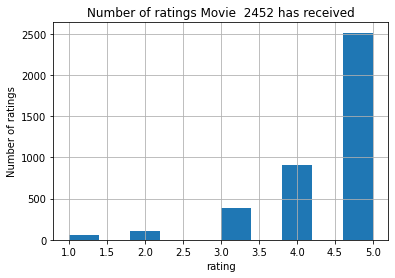

In [ ]:
new_train.loc[new_train['Movie_ID'] == 2452]['Rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Movie  2452 has received')
plt.show();

This most people have rated this movie a 5, so it is quite popular. It makes sense that many predictions for the rating of this movie will tend to be high. 

In [ ]:
new_train.loc[new_train['User_ID']==2482738]['Rating'].describe()


count    17.000000
mean      4.352941
std       1.114741
min       1.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: Rating, dtype: float64

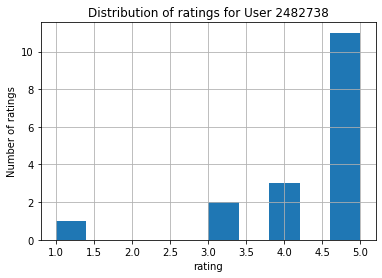

In [ ]:
new_train.loc[new_train['User_ID'] == 2482738]['Rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Distribution of ratings for User 2482738')
plt.show();

Most of the ratings for this user are possitive. SVD finds other relationships between users and items to make its predictions besides whether a user tends to rank movies highly. Nonetheless, I think it is enlighting to see that the model's predictions are not completely without sense. 

### Final thoughts 

In this project we explored Netflix's dataset that was use for its Kaggle recommender system competition. The dataset that I began working with was just a small portion of the actual dataset. But even then, I had to greatly reduce the dimentionality of my dataset, first by taking a sample (30%). I then further reduced the dimentionality by filtering out users that had rated less than 5% of movies and movies that had been rated by less than 5% of users. 

While such filtering may have been unfair, in real practice, companies do have to make choices for new customers (cold start problem). In this scenario, I am assuming that those customers that we filtered out will have to get recommendations based on another algorith and through questions we obtain from a questionaire.

We tested the reduced dataset on three different models: SVD, BaselineOnly, and KNNWithMeans. We obtained the best rmse scores from the SVD model which relies on Probabilistic Matrix Factorization. So we decided to move on with that model. 

We then try to find the best hyper-parameters for SVD using gridsearch, thereby reducing rmse from 0.91 to 0.88. 

After tuning our SVD model, we explored the errors, and we saw that on average, ratings were missed by 0.70 ratings points. We futher explored the distribution of errors and saw that a vast majority of ratings were mispredicted by 1 rating point or less. 

This simple SVD model provided very good predictions, the model does not need to be precise to generally make very good recommendations. If the model predicts a rating or 4 or more, if is very likely the user will enjoy the movie. If the model predicts a rating of 3 or less, it is quite likely the user will not enjoy this movie.  I do recognize that we filtered certain users and movies that would have led to a much greater distribution of errors, but in industry, there will always be that issue and in those cases, user can be recommended generally popular titles and/or be given a survey to help kick-start predictions.